# FML Classification Task

---

### Importing libraries and Data

In [1]:
#imports
import pandas as pd
from google.colab import drive
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn import preprocessing
from sklearn.decomposition import PCA
import random
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


#mounting drive for data importations
drive.mount('/content/drive')

#loading data from google drive CSVs
training1_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FML/Data/training1.csv")
training2_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FML/Data/training2.csv")
test_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FML/Data/test.csv")
sample_valid_predictions_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FML/Data/sample_valid_predictions.csv")

#converting data in 2D arrays
training1_array = training1_raw.values
print("training1 shape:", training1_array.shape)
training2_array = training2_raw.values
print("training2 shape:", training2_array.shape)
sample_valid_predictions_array = sample_valid_predictions_raw.values
print("sample valid predictions shape:", sample_valid_predictions_raw.shape)
test_array=test_raw.values
print("testing data shape:", test_array.shape)

Mounted at /content/drive
training1 shape: (500, 2306)
training2 shape: (2500, 2306)
sample valid predictions shape: (1000, 1)
testing data shape: (1000, 2304)


### Handy Functions

In [ ]:
def display_confusion_matrix(grounds, predictions):
  """
  Displays a confusion matrix for the given data.
  :param grounds: the ground truth points
  :param predictions: the predicted points
  """
  #create confusion matrix
  cm = confusion_matrix(grounds, predictions)

  #create displayable CM
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('Positive','Negative'))
  
  #display it
  disp.plot()
  plt.show()

## Preprocessing

In [6]:

# separating classes, features and uncertainties

t1_X = [column[0:-2:] for column in training1_array] # complete list of features
t2_X = [column[0:-2:] for column in training2_array] # incomplete list of features 
t1_y = [column[-2] for column in training1_array] #complete list's labels
t2_y = [column[-2] for column in training2_array] # incomplete list's labels
t1_z = [column[-1] for column in training1_array] # complete list's confidences
t2_z = [column[-1] for column in training2_array] # incomplete list's confidences
print("Data separation complete...")


def impute_data(k=5):
  """
  imputes any missing data from the incomplete feature list and combines it with the complete feature list. Does the same with confidences and 
  class labels
  :param k: The number of neighbours to use
  :returns X: the combined list of complete data and imputed, incomplete data.
  :returns y: the combined class labels
  :returns z: the combined confidence values
  """
  # create imputer
  imputer = KNNImputer(n_neighbors=k) 
  print("Data imputing started with",k,"neighbours.")
  # fit imputer to complete data
  imputer.fit(t1_X)

  # impute data with nan
  t2_X_imputed = imputer.transform(t2_X)

  # create whole dataset features
  X = np.concatenate((t1_X, t2_X_imputed), axis=0)
  # create whole dataset classes
  y = np.concatenate((t1_y, t2_y),axis=0)
  # create whole dataset confidences
  z = np.concatenate((t1_z, t2_z),axis=0)
  print("Data imputing done, datasets combined with shapes...")

  # ensure concatenation and imputing worked.
  print("X:", X.shape)
  print("y:", y.shape)
  print("z:", z.shape)
  assert len(np.where(np.isnan(X).any(axis=1))[0]) == 0, "NaN values have not been removed."
  return X, y, z

def scale_data(data):
  """
  scales data to have a mean of 0 and SD/variance of 1
  :param data: the set of features to scale/normalise
  
  :returns X: the scaled data
  """
  #scaling data to have mean 0, sd 1
  scaler = preprocessing.StandardScaler()
  X = scaler.fit_transform(data)
  print("Data scaled with mean 0, sd 1...")
  return X

X, y, z = impute_data(3)
X = scale_data(X)

Data separation complete...
Data imputing started with 3 neighbours.
Data imputing done, datasets combined with shapes...
X: (3000, 2304)
y: (3000,)
z: (3000,)
Data scaled with mean 0, sd 1...


### PCA (old, unused)


In [ ]:

# pca = PCA()
# X_train_pca = pca.fit_transform(X_train_scaled)

# eigenvalues = pca.explained_variance_
# print(eigenvalues.shape)

# variance_explained = eigenvalues / np.sum(eigenvalues)

# indices = pca.components_.argsort()[:, ::-1][:]

# print(pca.components_)

### Duplicating any data which has a confidence level of 1 to increase the weighting of those images. (old, unused)

In [ ]:
indices_with_confidence_1 = np.array(np.where(z == 1))[0]
indices_with_confidence_66 = np.array(np.where(z==0.66))[0]

# Duplicate elements in X and y with confidence value 1
duplicated_X = np.concatenate((X, X[indices_with_confidence_1]))
duplicated_y = np.concatenate((y, y[indices_with_confidence_1]))

# Replace the original X and y with the duplicated versions
print(duplicated_X.shape)
print(duplicated_y.shape)

(3773, 2304)
(3773,)


### Splitting Data

separating data into cnn and gist features is old and unused.

In [ ]:
#separate data into cnn and gist features, could be handy later.
X_cnn = X[:,0:2048:]
X_gist = X[:,2048::]

In [3]:
def split_data_weighted(): 
  """
  Separates the data into training data and testing data two confidence levels, 1 and 0.66.

  The returned training data has a ratio of 7:3 confidence 1 to confidence 0.66 data points
  The returned testing data has a ratio of 7:3 confidence 0.66 to confidence 1 data points
  This will hopefully reduce misclassifications fed into the SVM during training.     
    
    
  :returns X_train: the training data features.
  :returns y_train: the training data labels.
  :returns X_test: the testing data features.
  :returns y_test: the testing data labels.

    
  :Raises AssertionError: Confidence list separation failed: X items have been skipped or duplicated.
  :Raises AssertionError: Confidence list separation failed: y items have been skipped or duplicated.
  """


  #create seed 
  seed = random.randint(0,256)

  #find indices of confidence 1 and 0.66 items in training data.
  indices_with_confidence_1 = np.array(np.where(z == 1))[0]
  indices_with_confidence_66 = np.array(np.where(z==0.66))[0]

  #create list of features with confidence 1 and confidence 0.66
  X_conf_1 = X[indices_with_confidence_1]
  X_conf_66 = X[indices_with_confidence_66]

  #create list of labels with confidence 1 and confidence 0.66 that correspond to X_conf_1 and X_conf_66
  y_conf_1 = y[indices_with_confidence_1]
  y_conf_66 = y[indices_with_confidence_66]

  #some assertions to make sure things worked.
  assert len(X_conf_1) + len(X_conf_66) == len(X), "Confidence list separation failed: X items have been skipped or duplicated."
  assert len(y_conf_66) + len(y_conf_1) == len(y), "Confidence list separation failed: y items have been skipped or duplicated."


  # Split confidence 1 data into 70% training and 30% testing
  X_conf_1_train, X_conf_1_test = train_test_split(X_conf_1, test_size=0.3, random_state=seed)
  y_conf_1_train, y_conf_1_test = train_test_split(y_conf_1, test_size=0.3, random_state=seed)
  # Split confidence 0.66 data into 30% training and 70% testing
  X_conf_66_train, X_conf_66_test = train_test_split(X_conf_66, test_size=0.7, random_state=seed)
  y_conf_66_train, y_conf_66_test = train_test_split(y_conf_66, test_size=0.7, random_state=seed)

  # Combine the training data, with 70% of the data from confidence 1 and 30% of the data from confidence 0.66
  X_train = list(X_conf_1_train) + list(X_conf_66_train)
  y_train = list(y_conf_1_train) + list(y_conf_66_train)

  # Combine the testing data, with 30% of the data from X_conf_1 and 70% of the data from X_conf_66
  X_test = np.array(list(X_conf_1_test) + list(X_conf_66_test))
  y_test = np.array(list(y_conf_1_test) + list(y_conf_66_test))

  #more assertions to make sure everything worked.
  assert len(X_train) + len(X_test) == len(X), "Incorrect number of samples in X_train and X_test"
  assert len(y_train) + len(y_test) == len(y), "Incorrect number of samples in y_train and y_test"

  return X_train, y_train, X_test, y_test

## Getting baseline accuracy of the network with Default parameters.`

In [7]:
default_accs = []
X, y, z = impute_data()
for i in range(10):
  X_train, X_test, y_train, y_test_true = train_test_split(X,y,test_size = 0.2, random_state = seed, shuffle=True)
  clf=SVC()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  default_accs.append(accuracy_score(y_test_true, y_pred))
print(np.mean(default_accs))

Data imputing started with 5 neighbours.
Data imputing done, datasets combined with shapes...
X: (3000, 2304)
y: (3000,)
z: (3000,)
0.7416666666666668


## Performing a grid search over optimal SVM Kernels

Epoch 0 started.
rbf Accuracy: 0.7783333333333333
Linear Accuracy: 0.6333333333333333
Sigmoid Accuracy: 0.7733333333333333
Poly Accuracy: 0.735
Epoch 0 completed.

Epoch 1 started.
rbf Accuracy: 0.7633333333333333
Linear Accuracy: 0.6516666666666666
Sigmoid Accuracy: 0.7433333333333333
Poly Accuracy: 0.7083333333333334
Epoch 1 completed.

Epoch 2 started.
rbf Accuracy: 0.725
Linear Accuracy: 0.6266666666666667
Sigmoid Accuracy: 0.72
Poly Accuracy: 0.705
Epoch 2 completed.

Epoch 3 started.
rbf Accuracy: 0.7616666666666667
Linear Accuracy: 0.625
Sigmoid Accuracy: 0.7566666666666667
Poly Accuracy: 0.71
Epoch 3 completed.

Epoch 4 started.
rbf Accuracy: 0.76
Linear Accuracy: 0.6166666666666667
Sigmoid Accuracy: 0.7516666666666667
Poly Accuracy: 0.69
Epoch 4 completed.

Epoch 5 started.
rbf Accuracy: 0.7383333333333333
Linear Accuracy: 0.6166666666666667
Sigmoid Accuracy: 0.7283333333333334
Poly Accuracy: 0.705
Epoch 5 completed.

Epoch 6 started.
rbf Accuracy: 0.7583333333333333
Linear Ac

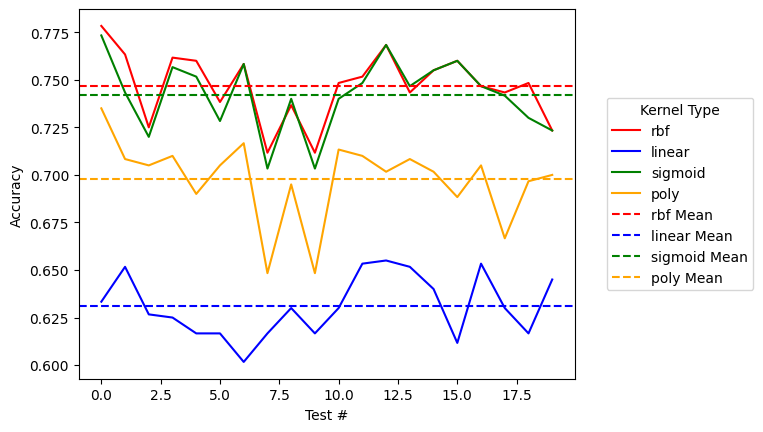



Average RBF accuracy: 0.7466666666666666
Average Linear accuracy: 0.6310833333333334
Average Sigmoid accuracy: 0.7419166666666667
Average Poly accuracy: 0.6976666666666665


In [ ]:
# initialise accuracy arrays
rbf_accs = []
lin_accs = []
sig_accs = []
pol_accs = []

# do test 10 times for fairness
for i in range(20):
  print('Epoch',i,'started.')
  seed = random.randint(0,256)
  X_train, X_test, y_train, y_test_true = train_test_split(X,y,test_size = 0.2, random_state = seed, shuffle=True)
  
  # rbf (default)
  clf=SVC(kernel='rbf')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  rbf_accs.append(accuracy_score(y_test_true, y_pred))
  print('rbf Accuracy:', accuracy_score(y_test_true, y_pred))

  # linear
  clf=SVC(kernel='linear')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  lin_accs.append(accuracy_score(y_test_true, y_pred))
  print('Linear Accuracy:', accuracy_score(y_test_true, y_pred))

  # sigmoid
  clf=SVC(kernel='sigmoid')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  sig_accs.append(accuracy_score(y_test_true, y_pred))
  print('Sigmoid Accuracy:', accuracy_score(y_test_true, y_pred))

  # poly
  clf=SVC(kernel='poly')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  pol_accs.append(accuracy_score(y_test_true, y_pred))
  print('Poly Accuracy:', accuracy_score(y_test_true, y_pred))

  print('Epoch',i,'completed.')
  print("")


# plot lines
plt.plot(rbf_accs, label='rbf', c='r')
plt.plot(lin_accs, label='linear', c='b')
plt.plot(sig_accs, label='sigmoid', c='g')
plt.plot(pol_accs, label='poly', c='orange')

# plot means
plt.axhline(y=np.mean(rbf_accs), color='red', linestyle='--', label='rbf Mean')
plt.axhline(y=np.mean(lin_accs), color='blue', linestyle='--', label='linear Mean')
plt.axhline(y=np.mean(sig_accs), color='green', linestyle='--', label='sigmoid Mean')
plt.axhline(y=np.mean(pol_accs), color='orange', linestyle='--', label='poly Mean')

plt.xlabel('Test #')
plt.ylabel('Accuracy')
legend = plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
# Changing the title of the legend
legend.set_title('Kernel Type')
plt.show()


print("")
print("")
print("Average RBF accuracy:", np.mean(rbf_accs))
print("Average Linear accuracy:", np.mean(lin_accs))
print("Average Sigmoid accuracy:", np.mean(sig_accs))
print("Average Poly accuracy:", np.mean(pol_accs))


##Creating & using Grid search on SVM for predictions

Grid search for best parameters with default test split


In [ ]:
#create parameter grid
param_grid = {'C': [0.1, 1, 10, 25, 50, 100], 'kernel': ['sigmoid', 'rbf'], 'gamma': ['scale', 'auto', 0.01, 0.1, 0.5, 1, 1.5]}

#split data
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, shuffle=True )

#create SV classifier
svc = SVC()
#create grid. score for accuracy and use maximum possible cores while avoiding high RAM usage
grid = GridSearchCV(svc, param_grid, scoring='accuracy', n_jobs = -1, cv=5, pre_dispatch='2*n_jobs')

#fit grid to training data. Use data's confidence values as weights.
grid.fit(X_train, y_train, sample_weight=z_train)

#print best parameters with score.
print("Best parameters: ", grid.best_params_)

#test best paraneters on new data.
best_svc = grid.best_estimator_
test_score = best_svc.score(X_test, y_test)
print("Test score: ", test_score)

Best parameters:  {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}
Test score:  0.7633333333333333


## Grid search for best parameters with weighted test split



In [ ]:
#create parameter grid
param_grid = {'C': [0.1, 1, 10, 25, 50, 100], 'kernel': ['sigmoid', 'rbf'], 'gamma': ['scale', 'auto', 0.01, 0.1, 0.5, 1, 1.5]}

#split data using weighted data splitter
X_train, y_train, X_test, y_test = split_data_weighted() 

#create SV classifer
svc = SVC()
#create grid. score for accuracy and use maximum possible cores while avoiding high ram usage
grid = GridSearchCV(svc, param_grid, scoring='accuracy', n_jobs = -1, cv=5, pre_dispatch='2*n_jobs')

#fit grid to training data
grid.fit(X_train, y_train)

#print best parameters with score.
print("Best parameters: ", grid.best_params_)

best_svc = grid.best_estimator_
test_score = best_svc.score(X_test, y_test)
print("Test score: ", test_score)

Best parameters:  {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}
Test score:  0.7426018983807928


# Testing Different Neighbourhood sizes for KNN-Imputing

In [ ]:
# setting different neighbourhood sizes
neighbourhood_sizes = [3,5,7,9,11,13,15,17,19,21]

# Initialise accuracy array
multi_test_accuracies = []

# Repeat tests 20 times to ensure fairness
for i in range(20):
  # Initialise inner accuracy array
  accuracies = []
  # for each neighbourhood size...
  for k in neighbourhood_sizes:
    # impute missing data with k neighbours
    X, y, z = impute_data(k)
    # scale data to mean 0 SD 1
    X = scale_data(data=X)
    # split data using default train-test split
    X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.1, shuffle=True )
    # Train an SVC with optimised parameters found from grid search
    svc = SVC(kernel='rbf', C=1, gamma="scale")
    # Fit SVC with z-train weights.
    svc.fit(X_train, y_train, sample_weight=z_train)
    # Predict classes for testing data
    y_pred = svc.predict(X_test)
    # add accuracy score to inner accuracies list
    accuracies.append(accuracy_score(y_test, y_pred))
  # add accuracy score to outer accuracy list
  multi_test_accuracies.append(accuracies)

# Calculate mean accuracies for all neighbourhood sizes
mean_accuracies = np.mean(multi_test_accuracies, axis=(0))

# plot mean accuracy sizes in red
plt.plot(neighbourhood_sizes, mean_accuracies, label='Mean Accuracy',c='r')
# plot all tests
for i, test in enumerate(multi_test_accuracies):
  label = 'Test ' + str(i)
  plt.plot(neighbourhood_sizes, test, linestyle=":", alpha=0.5)
  
# make plot look pretty & show it
plt.legend(loc='upper right')
plt.xlabel('Neighbourhood Size')
plt.ylabel('Accuracy')
plt.show()

# Creating predictions for Test Data & Exporting


In [21]:
testing = test_array

final_imputer = KNNImputer(n_neighbors=17)

t1_X = [column[0:-2:] for column in training1_array] # complete list of features
final_imputer.fit(t1_X)

testing_imputed = final_imputer.transform(testing)


X_test = scale_data(testing_imputed)


X_train, y_train, z_train = impute_data(17)
X_train = scale_data(X_train)

clf=SVC(C=1, gamma='scale', kernel='sigmoid')
clf.fit(X_train, y_train, sample_weight=z_train)

predictions = clf.predict(X_test)

int_predictions = np.array([int(num) for num in predictions])
print(int_predictions)
assert len(int_predictions) == len(test_array), 'mismatched number of predictions and data samples.'
assert int_predictions.shape ==(1000,), 'predictions are wrong shape'
np.savetxt('/content/drive/MyDrive/Colab Notebooks/FML/new_predictions.csv', int_predictions, delimiter=',')

[1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1
 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1
 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1
 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1
 1 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1
 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0
 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1
 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1
 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1
 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1
 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0
 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0
 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 